In [1]:
#pip install -U datasets

In [2]:
#pip install -U peft

In [3]:
# pip install -U bitsandbytes

In [4]:
# -U transformerspip install 

In [5]:
# pip install --upgrade transformers

In [6]:
# pip install --upgrade transformers peft

In [7]:
# pip install evaluate


In [1]:
import torch
import torch.distributed
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, Trainer, TrainingArguments, PreTrainedTokenizer, BitsAndBytesConfig
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training

import copy
from dataclasses import dataclass, field
from typing import Optional, Dict, Sequence
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameter Configuration

In [4]:
# Hyperparameters
CONFIG_PATH = "./"
MODEL_NAME = "deepseek-ai/deepseek-coder-1.3b-instruct"
MODEL_PATH = "./pytorch_model.bin"
current_model = 'current_model'
Last_finetuned_model = "./checkpoint-5500/" 


DATA_PATH = "./data/train_spider.json"
OUTPUT_DIR = "./fine_tuned_model/"         # Directory to save the fine-tuned model
CACHE_DIR = "./cache/"                     # Directory for caching datasets

# Training hyperparameters
PER_DEVICE_TRAIN_BATCH_SIZE = 4
NUM_TRAIN_EPOCHS = 1
LEARNING_RATE = 5e-5
LOGGING_STEPS = 50
Eval_Steps = 200
SAVE_STEPS = 500
MODEL_MAX_LENGTH = 2048           # Maximum sequence length 512
max_new_tokens = 100

# Other configurations
USE_BFLOAT16 = True
NUM_PROC = 1
BATCH_SIZE_FOR_TOKENIZATION = 3000
TRUST_REMOTE_CODE = True

In [5]:
MODEL_MAX_LENGTH = max_new_tokens

## Helper Functions and Data Classes

In [11]:
IGNORE_INDEX = -100
EOT_TOKEN = "<|EOT|>"

def build_instruction_prompt(instruction: str) -> str:
    return '''
You are an AI programming assistant, utilizing the DeepSeek Coder model, developed by DeepSeek Company, and you only answer questions related to computer science. For politically sensitive questions, security and privacy issues, and other non-computer science questions, you will refuse to answer.
### Instruction:
{}
### Response:
'''.format(instruction.strip()).lstrip()

@dataclass
class ModelArguments:
    model_name_or_path: Optional[str] = field(default=MODEL_PATH)

@dataclass
class DataArguments:
    data_path: str = field(default=DATA_PATH, metadata={"help": "Path to the training data."})

@dataclass
class CustomTrainingArguments(TrainingArguments):
    cache_dir: Optional[str] = field(default=CACHE_DIR)
    optim: str = field(default="adamw_torch")
    model_max_length: int = field(
        default=MODEL_MAX_LENGTH,
        metadata={"help": "Maximum sequence length. Sequences will be right padded (and possibly truncated)."},
    )

def safe_save_model_for_hf_trainer(trainer: Trainer, output_dir: str):
    """Collects the state dict and dump to disk."""
    state_dict = trainer.model.state_dict()
    if trainer.args.should_save:
        cpu_state_dict = {key: value.cpu() for key, value in state_dict.items()}
        del state_dict
        trainer._save(output_dir, state_dict=cpu_state_dict)  # noqa

def _tokenize_fn(strings: Sequence[str], tokenizer: PreTrainedTokenizer) -> Dict:
    """Tokenize a list of strings."""
    tokenized_list = [
        tokenizer(
            text,
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=True,
        )
        for text in strings
    ]

    input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
    input_ids_lens = labels_lens = [
        tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
    ]

    return dict(
        input_ids=input_ids,
        labels=labels,
        input_ids_lens=input_ids_lens,
        labels_lens=labels_lens,
    )

def preprocess(
    sources: Sequence[str],
    targets: Sequence[str],
    tokenizer: PreTrainedTokenizer,
) -> Dict:
    """Preprocess the data by tokenizing."""
    examples = [s + t for s, t in zip(sources, targets)]
    examples_tokenized, sources_tokenized = [_tokenize_fn(strings, tokenizer) for strings in (examples, sources)]
    input_ids = examples_tokenized["input_ids"]

    labels = copy.deepcopy(input_ids)
    for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
        label[:source_len] = IGNORE_INDEX
    return dict(input_ids=input_ids, labels=labels)

@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""
    tokenizer: PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = [torch.tensor(x) for x in input_ids]
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = [torch.tensor(x) for x in labels]
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=IGNORE_INDEX)

        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

def train_tokenize_function(examples, tokenizer):
    sources = [
        build_instruction_prompt(instruction)
        for instruction in examples['instruction']
    ]
    targets = [f"{output}\n{EOT_TOKEN}" for output in examples['output']]
    data_dict = preprocess(sources, targets, tokenizer)
    return data_dict


## Data Preparation

In [12]:
from datasets import load_dataset

ds = load_dataset("NumbersStation/NSText2SQL")


In [13]:
def split_dataset(dataset, eval_ratio=0.1, train_ratio=0.8, test_ratio=0.1):
    """
    Split the Hugging Face dataset into evaluation, training, and test sets.

    Parameters:
    dataset (Dataset): The dataset loaded using `load_dataset`.
    eval_ratio (float): Proportion of the dataset to be used for evaluation.
    train_ratio (float): Proportion of the dataset to be used for training.
    test_ratio (float): Proportion of the dataset to be used for testing.

    Returns:
    tuple: A tuple containing (train_set, eval_set, test_set).
    """
    # Ensure the ratios sum to 1
    assert eval_ratio + train_ratio + test_ratio == 1, "Ratios must sum to 1"

    # First, split the dataset into train+temp (train + eval/test)
    train_test_split = dataset.train_test_split(test_size=(eval_ratio + test_ratio))

    # From the remaining (eval + test), split it into eval and test
    eval_test_split = train_test_split['test'].train_test_split(test_size=(test_ratio / (eval_ratio + test_ratio)))

    # Return the splits
    return train_test_split['train'], eval_test_split['train'], eval_test_split['test']

In [14]:
train_split = ds['train']

# Split the dataset
train_set, eval_set, test_set = split_dataset(train_split)

# Example to show the result
print("Training Set Size:", len(train_set))
print("Evaluation Set Size:", len(eval_set))
print("Test Set Size:", len(test_set))

Training Set Size: 231430
Evaluation Set Size: 28929
Test Set Size: 28929


In [15]:
# def filter_datasets_by_sources(train_set, eval_set, test_set, source_values=['spider', 'another_source']):
#     """
#     Filters the input datasets based on the 'source' column matching any value in the given source_values list.

#     Args:
#         train_set: The training dataset.
#         eval_set: The evaluation dataset.
#         test_set: The test dataset.
#         source_values (list): A list of values in the 'source' column to filter by (default includes 'spider' and 'another_source').

#     Returns:
#         tuple: A tuple containing the filtered train_set, eval_set, and test_set.
#     """
#     # Using the filter method for each dataset and checking if the source is in source_values
#     filtered_train_set = train_set.filter(lambda example: example['source'] in source_values)
#     filtered_eval_set = eval_set.filter(lambda example: example['source'] in source_values)
#     filtered_test_set = test_set.filter(lambda example: example['source'] in source_values)
    
#     return filtered_train_set, filtered_eval_set, filtered_test_set


In [16]:
# filtered_train, filtered_eval,filtered_test = filter_datasets_by_sources(train_set, eval_set, test_set,['mimic_iii','mimicsql_data'])

In [17]:
from datasets import load_from_disk, DatasetDict
import os

In [18]:
# model_args = ModelArguments(model_name_or_path=MODEL_PATH)
model_args = ModelArguments(model_name_or_path=OUTPUT_DIR)
data_args = DataArguments(data_path=DATA_PATH)
training_args = CustomTrainingArguments(
    output_dir=OUTPUT_DIR,
    cache_dir=CACHE_DIR,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size = PER_DEVICE_TRAIN_BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    logging_steps=LOGGING_STEPS,
    save_steps=SAVE_STEPS,
    eval_steps=Eval_Steps,
    evaluation_strategy="steps",
    optim="adamw_torch",
    model_max_length=MODEL_MAX_LENGTH,
    report_to='tensorboard',
    # gradient_accumulation_steps=16,
)

def train_tokenize_function(examples):
    sources = [
        build_instruction_prompt(instruction)
        for instruction in examples['instruction']
    ]
    targets = [f"{output}\n{EOT_TOKEN}" for output in examples['output']]
    data_dict = preprocess(sources, targets, tokenizer)
    return data_dict

# Load the dataset
#raw_train_datasets = train_split.select(range(1000))
raw_train_datasets = train_set
raw_eval_datasets = eval_set
#tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR, trust_remote_code=True)

# Tokenize the dataset
# train_dataset = raw_train_datasets.map(
#     train_tokenize_function,
#     batched=True,
#     batch_size=BATCH_SIZE_FOR_TOKENIZATION,
#     num_proc=NUM_PROC,
#     remove_columns=raw_train_datasets.column_names,
#     load_from_cache_file=True,  # Set to False to overwrite cache
#     desc="Running Encoding",
# )

# Define the cache directory for the tokenized dataset
TOKENIZED_DATASET_PATH = os.path.join(OUTPUT_DIR, "tokenized_data")

# Check if the tokenized dataset exists
train_dataset = load_from_disk(TOKENIZED_DATASET_PATH)
eval_dataset = load_from_disk(TOKENIZED_DATASET_PATH+"/evaluation")

# if os.path.exists(TOKENIZED_DATASET_PATH+"/to make it false"):
#     print("Loading tokenized dataset from cache...")
#     #train_dataset = load_from_disk(TOKENIZED_DATASET_PATH)
#     eval_dataset = load_from_disk(TOKENIZED_DATASET_PATH+"/evluation")
# else:
#     print("Tokenizing dataset...")
    
#     # Tokenize the dataset
#     # train_dataset = raw_train_datasets.map(
#     #     train_tokenize_function,
#     #     batched=True,
#     #     batch_size=BATCH_SIZE_FOR_TOKENIZATION,
#     #     num_proc=NUM_PROC,
#     #     remove_columns=raw_train_datasets.column_names,
#     #     load_from_cache_file=True,  # Set to False to overwrite cache during tokenization
#     #     desc="Running Encoding",
#     # )
#     eval_dataset = raw_eval_datasets.map(
#         train_tokenize_function,
#         batched=True,
#         batch_size=BATCH_SIZE_FOR_TOKENIZATION,
#         num_proc=NUM_PROC,
#         remove_columns=raw_eval_datasets.column_names,
#         load_from_cache_file=True,  # Set to False to overwrite cache during tokenization
#         desc="Running Encoding",
#     )
    

#     # Save the tokenized dataset to disk
#     #train_dataset.save_to_disk(TOKENIZED_DATASET_PATH)
#     eval_dataset.save_to_disk(TOKENIZED_DATASET_PATH+"/evaluation")
#     print(f"Tokenized dataset saved at {TOKENIZED_DATASET_PATH}")


/home/youssefm/.local/lib/python3.8/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Model and Tokenizer Initialization

In [19]:
# config = AutoConfig.from_pretrained(MODEL_NAME)
# # Set up BitsAndBytesConfig
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
# )
# model = AutoModelForCausalLM.from_pretrained(
#     MODEL_NAME,
#     config=config,
#     trust_remote_code=TRUST_REMOTE_CODE,
#     quantization_config=bnb_config,
#     device_map="auto",
#     torch_dtype=torch.bfloat16)
# model = prepare_model_for_kbit_training(model)

# # Set up LoRA configuration
# peft_config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     target_modules=["q_proj", "v_proj","k_proj"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM",
# )

# # Apply LoRA to the model
# model = get_peft_model(model, peft_config)

# # Enable gradient checkpointing
# #model.gradient_checkpointing_enable()

# model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# # Verify special tokens
# print("PAD Token:", tokenizer.pad_token, tokenizer.pad_token_id)
# print("BOS Token:", tokenizer.bos_token, tokenizer.bos_token_id)
# print("EOS Token:", tokenizer.eos_token, tokenizer.eos_token_id)


## Continue Fine-tuning

In [20]:
# Load the fine-tuned model configuration and tokenizer
config = AutoConfig.from_pretrained(MODEL_NAME)

fine_tuned_tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR, trust_remote_code=TRUST_REMOTE_CODE)

# Set up BitsAndBytesConfig for continued training
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    config=config,
    trust_remote_code=TRUST_REMOTE_CODE,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16)

model = PeftModel.from_pretrained(base_model,OUTPUT_DIR)

# Prepare the model for k-bit training
model = prepare_model_for_kbit_training(model)

# Set up LoRA configuration for continued training
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj","gate_proj", "up_proj","down_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

# Apply LoRA to the model for continued fine-tuning
model = get_peft_model(model, peft_config)

# Enable gradient checkpointing (optional)
# model.gradient_checkpointing_enable()

# Move the model to the appropriate device
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Verify special tokens
print("PAD Token:", fine_tuned_tokenizer.pad_token, fine_tuned_tokenizer.pad_token_id)
print("BOS Token:", fine_tuned_tokenizer.bos_token, fine_tuned_tokenizer.bos_token_id)
print("EOS Token:", fine_tuned_tokenizer.eos_token, fine_tuned_tokenizer.eos_token_id)


PAD Token: <｜end▁of▁sentence｜> 32014
BOS Token: <｜begin▁of▁sentence｜> 32013
EOS Token: <|EOT|> 32021


In [22]:
model.print_trainable_parameters()

trainable params: 6,709,248 || all params: 1,353,181,184 || trainable%: 0.4958


## Training Setup

In [23]:
from nltk.translate.bleu_score import sentence_bleu

def compute_metrics(pred):
    references = pred.label_ids
    generated_texts = pred.predictions

    bleu_scores = []
    
    for reference_ids, generated_ids in zip(references, generated_texts):
        # Decode the token IDs back into text strings
        reference_text = tokenizer.decode(reference_ids, skip_special_tokens=True)
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        
        # Compute BLEU score using the decoded reference and generated text
        bleu_score = sentence_bleu([reference_text.split()], generated_text.split())
        bleu_scores.append(bleu_score)

    # Calculate the average BLEU score
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    
    return {'bleu': avg_bleu}


In [24]:
# pip install tensorboardX

In [25]:
import os
# Initialize the data collator
data_collator = DataCollatorForSupervisedDataset(tokenizer=fine_tuned_tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    #tokenizer=tokenizer,
    tokenizer=fine_tuned_tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset.select(range(100)),          # evaluation dataset
    #compute_metrics=compute_metrics,
    data_collator=data_collator,
)
# # Load the optimizer and scheduler states
# if os.path.exists(os.path.join(Last_finetuned_model, "optimizer.pt")):
#     optimizer_state = torch.load(os.path.join(current_model, "optimizer.pt"))
#     trainer.optimizer.load_state_dict(optimizer_state)

# if os.path.exists(os.path.join(Last_finetuned_model, "scheduler.pt")):
#     scheduler_state = torch.load(os.path.join(current_model, "scheduler.pt"))
#     trainer.lr_scheduler.load_state_dict(scheduler_state)

<ipython-input-25-3134d34f9b49>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
train_dataset

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 231430
})

## Training Execution

In [28]:
# Start training
# trainer.add_callback(CustomCallback(trainer)) 
#trainer.train()
trainer.train(resume_from_checkpoint=True)

/home/youssefm/.local/lib/python3.8/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_N

  0%|          | 0/57858 [00:00<?, ?it/s]

/home/youssefm/.local/lib/python3.8/site-packages/transformers/trainer.py:3026: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = torch.load(rng_file)
`us

{'loss': 0.044, 'grad_norm': 0.023601671680808067, 'learning_rate': 2.4266307165819767e-06, 'epoch': 0.95}
{'loss': 0.0402, 'grad_norm': 0.3385719656944275, 'learning_rate': 2.383421480175602e-06, 'epoch': 0.95}
{'loss': 0.0256, 'grad_norm': 0.024273375049233437, 'learning_rate': 2.3402122437692284e-06, 'epoch': 0.95}
{'loss': 0.0477, 'grad_norm': 0.9430955052375793, 'learning_rate': 2.297003007362854e-06, 'epoch': 0.95}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03678399696946144, 'eval_runtime': 82.7309, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 0.95}
{'loss': 0.0175, 'grad_norm': 1.2619025707244873, 'learning_rate': 2.2537937709564797e-06, 'epoch': 0.95}
{'loss': 0.031, 'grad_norm': 0.5274714231491089, 'learning_rate': 2.2105845345501056e-06, 'epoch': 0.96}
{'loss': 0.0269, 'grad_norm': 0.09186811000108719, 'learning_rate': 2.167375298143731e-06, 'epoch': 0.96}
{'loss': 0.0582, 'grad_norm': 1.596091866493225, 'learning_rate': 2.1241660617373574e-06, 'epoch': 0.96}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03674459829926491, 'eval_runtime': 82.7759, 'eval_samples_per_second': 1.208, 'eval_steps_per_second': 0.302, 'epoch': 0.96}
{'loss': 0.0527, 'grad_norm': 1.4869619607925415, 'learning_rate': 2.080956825330983e-06, 'epoch': 0.96}
{'loss': 0.0577, 'grad_norm': 0.12333650141954422, 'learning_rate': 2.0377475889246087e-06, 'epoch': 0.96}


/home/youssefm/.local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/youssefm/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 0.0411, 'grad_norm': 0.9370870590209961, 'learning_rate': 1.994538352518234e-06, 'epoch': 0.96}
{'loss': 0.0329, 'grad_norm': 0.9234450459480286, 'learning_rate': 1.95132911611186e-06, 'epoch': 0.96}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03667621314525604, 'eval_runtime': 82.7984, 'eval_samples_per_second': 1.208, 'eval_steps_per_second': 0.302, 'epoch': 0.96}
{'loss': 0.0392, 'grad_norm': 0.3251405358314514, 'learning_rate': 1.908119879705486e-06, 'epoch': 0.96}
{'loss': 0.0315, 'grad_norm': 0.4416637122631073, 'learning_rate': 1.8649106432991118e-06, 'epoch': 0.96}
{'loss': 0.0684, 'grad_norm': 0.19054841995239258, 'learning_rate': 1.8217014068927374e-06, 'epoch': 0.96}
{'loss': 0.0376, 'grad_norm': 0.43192610144615173, 'learning_rate': 1.7784921704863633e-06, 'epoch': 0.96}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.036651838570833206, 'eval_runtime': 82.8559, 'eval_samples_per_second': 1.207, 'eval_steps_per_second': 0.302, 'epoch': 0.96}
{'loss': 0.0427, 'grad_norm': 0.71455979347229, 'learning_rate': 1.735282934079989e-06, 'epoch': 0.97}
{'loss': 0.04, 'grad_norm': 0.5503489971160889, 'learning_rate': 1.6920736976736147e-06, 'epoch': 0.97}
{'loss': 0.0409, 'grad_norm': 0.34252259135246277, 'learning_rate': 1.6488644612672407e-06, 'epoch': 0.97}
{'loss': 0.0706, 'grad_norm': 0.6078123450279236, 'learning_rate': 1.6056552248608664e-06, 'epoch': 0.97}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03666699305176735, 'eval_runtime': 82.8867, 'eval_samples_per_second': 1.206, 'eval_steps_per_second': 0.302, 'epoch': 0.97}


/home/youssefm/.local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/youssefm/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 0.0786, 'grad_norm': 1.208923101425171, 'learning_rate': 1.562445988454492e-06, 'epoch': 0.97}
{'loss': 0.0441, 'grad_norm': 0.26786670088768005, 'learning_rate': 1.5192367520481177e-06, 'epoch': 0.97}
{'loss': 0.0521, 'grad_norm': 0.36040398478507996, 'learning_rate': 1.4760275156417436e-06, 'epoch': 0.97}
{'loss': 0.0586, 'grad_norm': 0.1495690643787384, 'learning_rate': 1.4328182792353695e-06, 'epoch': 0.97}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.036552201956510544, 'eval_runtime': 82.7095, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 0.97}
{'loss': 0.0334, 'grad_norm': 0.20244568586349487, 'learning_rate': 1.3896090428289954e-06, 'epoch': 0.97}
{'loss': 0.0702, 'grad_norm': 0.08082164824008942, 'learning_rate': 1.346399806422621e-06, 'epoch': 0.97}
{'loss': 0.0428, 'grad_norm': 0.6021929383277893, 'learning_rate': 1.3031905700162467e-06, 'epoch': 0.97}
{'loss': 0.0562, 'grad_norm': 0.8553938865661621, 'learning_rate': 1.2599813336098726e-06, 'epoch': 0.97}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.036557428538799286, 'eval_runtime': 82.733, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 0.97}
{'loss': 0.0503, 'grad_norm': 0.14579764008522034, 'learning_rate': 1.2167720972034982e-06, 'epoch': 0.98}
{'loss': 0.0391, 'grad_norm': 0.19747088849544525, 'learning_rate': 1.173562860797124e-06, 'epoch': 0.98}


/home/youssefm/.local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/youssefm/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 0.0338, 'grad_norm': 1.237080454826355, 'learning_rate': 1.1303536243907498e-06, 'epoch': 0.98}
{'loss': 0.0447, 'grad_norm': 0.15039557218551636, 'learning_rate': 1.0871443879843756e-06, 'epoch': 0.98}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03655203804373741, 'eval_runtime': 82.7297, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 0.98}
{'loss': 0.0412, 'grad_norm': 0.2595243453979492, 'learning_rate': 1.0439351515780015e-06, 'epoch': 0.98}
{'loss': 0.0391, 'grad_norm': 0.6539934277534485, 'learning_rate': 1.0007259151716272e-06, 'epoch': 0.98}
{'loss': 0.0443, 'grad_norm': 0.314424067735672, 'learning_rate': 9.575166787652528e-07, 'epoch': 0.98}
{'loss': 0.0274, 'grad_norm': 0.04362725466489792, 'learning_rate': 9.143074423588787e-07, 'epoch': 0.98}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03652755171060562, 'eval_runtime': 82.7241, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 0.98}
{'loss': 0.0638, 'grad_norm': 0.33522844314575195, 'learning_rate': 8.710982059525044e-07, 'epoch': 0.98}
{'loss': 0.0416, 'grad_norm': 0.14580217003822327, 'learning_rate': 8.278889695461303e-07, 'epoch': 0.98}
{'loss': 0.0363, 'grad_norm': 0.01248712744563818, 'learning_rate': 7.84679733139756e-07, 'epoch': 0.98}
{'loss': 0.053, 'grad_norm': 0.5822107195854187, 'learning_rate': 7.414704967333818e-07, 'epoch': 0.99}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03655165061354637, 'eval_runtime': 82.6906, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 0.99}


/home/youssefm/.local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/youssefm/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 0.0223, 'grad_norm': 0.21649278700351715, 'learning_rate': 6.982612603270076e-07, 'epoch': 0.99}
{'loss': 0.0392, 'grad_norm': 0.003223621752113104, 'learning_rate': 6.550520239206332e-07, 'epoch': 0.99}
{'loss': 0.0394, 'grad_norm': 0.11201288551092148, 'learning_rate': 6.118427875142591e-07, 'epoch': 0.99}
{'loss': 0.0548, 'grad_norm': 0.8702112436294556, 'learning_rate': 5.686335511078849e-07, 'epoch': 0.99}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03653324395418167, 'eval_runtime': 82.8219, 'eval_samples_per_second': 1.207, 'eval_steps_per_second': 0.302, 'epoch': 0.99}
{'loss': 0.0739, 'grad_norm': 0.8246235847473145, 'learning_rate': 5.254243147015107e-07, 'epoch': 0.99}
{'loss': 0.0421, 'grad_norm': 0.5853354334831238, 'learning_rate': 4.822150782951363e-07, 'epoch': 0.99}
{'loss': 0.0404, 'grad_norm': 0.48411446809768677, 'learning_rate': 4.3900584188876214e-07, 'epoch': 0.99}
{'loss': 0.0437, 'grad_norm': 0.11849117279052734, 'learning_rate': 3.957966054823879e-07, 'epoch': 0.99}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03651381656527519, 'eval_runtime': 82.6855, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 0.99}
{'loss': 0.0542, 'grad_norm': 0.22481176257133484, 'learning_rate': 3.525873690760137e-07, 'epoch': 0.99}
{'loss': 0.023, 'grad_norm': 1.0457844734191895, 'learning_rate': 3.0937813266963945e-07, 'epoch': 0.99}


/home/youssefm/.local/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/youssefm/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


{'loss': 0.0461, 'grad_norm': 0.9782543182373047, 'learning_rate': 2.661688962632653e-07, 'epoch': 0.99}
{'loss': 0.0506, 'grad_norm': 0.9927903413772583, 'learning_rate': 2.2295965985689102e-07, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03650696575641632, 'eval_runtime': 82.7391, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 1.0}
{'loss': 0.043, 'grad_norm': 0.03265263885259628, 'learning_rate': 1.797504234505168e-07, 'epoch': 1.0}
{'loss': 0.0465, 'grad_norm': 0.7452994585037231, 'learning_rate': 1.3654118704414256e-07, 'epoch': 1.0}
{'loss': 0.0372, 'grad_norm': 0.28044766187667847, 'learning_rate': 9.333195063776833e-08, 'epoch': 1.0}
{'loss': 0.0332, 'grad_norm': 0.3012888431549072, 'learning_rate': 5.012271423139411e-08, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03649426996707916, 'eval_runtime': 82.7185, 'eval_samples_per_second': 1.209, 'eval_steps_per_second': 0.302, 'epoch': 1.0}
{'loss': 0.056, 'grad_norm': 0.4811643064022064, 'learning_rate': 6.9134778250198765e-09, 'epoch': 1.0}
{'train_runtime': 36205.464, 'train_samples_per_second': 6.392, 'train_steps_per_second': 1.598, 'train_loss': 0.002205635783250285, 'epoch': 1.0}


TrainOutput(global_step=57858, training_loss=0.002205635783250285, metrics={'train_runtime': 36205.464, 'train_samples_per_second': 6.392, 'train_steps_per_second': 1.598, 'total_flos': 2.262434057138602e+18, 'train_loss': 0.002205635783250285, 'epoch': 1.0})

In [41]:
import pandas as pd
states_history = pd.DataFrame(trainer.state.log_history)

In [42]:
states_history.to_csv("trainingforfivedays.csv")

In [43]:
states_history

,epoch,grad_norm,learning_rate,loss,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.000864,1.415033,4.995679e-05,0.3888,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001728,1.893022,4.991358e-05,0.2819,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.002593,1.130549,4.987037e-05,0.2351,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.003457,1.203145,4.982716e-05,0.1786,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.003457,NaN,NaN,NaN,200,0.206357,87.8517,1.138,0.285,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442,0.998133,0.280448,9.333195e-08,0.0372,57750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1443,0.998998,0.301289,5.012271e-08,0.0332,57800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1444,0.998998,NaN,NaN,NaN,57800,0.036494,82.7185,1.209,0.302,NaN,NaN,NaN,NaN,NaN
1445,0.999862,0.481164,6.913478e-09,0.0560,57850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


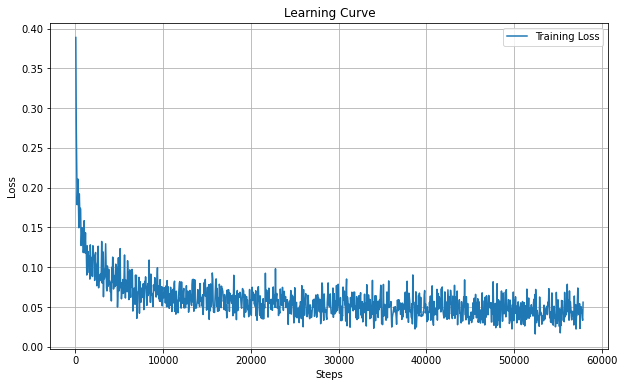

In [44]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

# Retrieve all loss entries and their corresponding steps
train_steps = [entry['step'] for entry in history if 'loss' in entry]
train_losses = [entry['loss'] for entry in history if 'loss' in entry]


# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


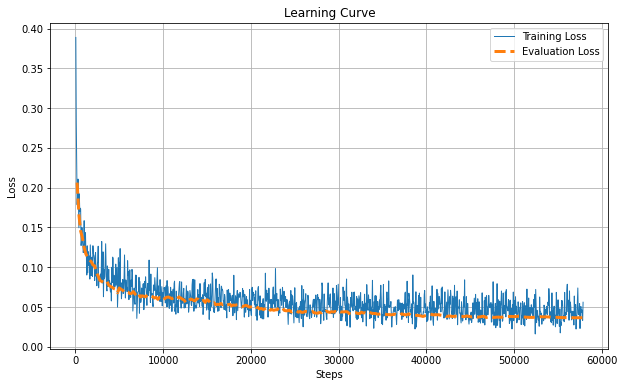

In [45]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

# Retrieve all training loss entries and their corresponding steps
train_steps = [entry['step'] for entry in history if 'loss' in entry]
train_losses = [entry['loss'] for entry in history if 'loss' in entry]

# Retrieve all evaluation loss entries and their corresponding steps
eval_steps = [entry['step'] for entry in history if 'eval_loss' in entry]
eval_losses = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss",linewidth=1)
plt.plot(eval_steps, eval_losses, label="Evaluation Loss", linestyle='--',linewidth=3)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

## Saving the Fine-Tuned Model

In [47]:
trainer.save_state()
safe_save_model_for_hf_trainer(trainer=trainer, output_dir=training_args.output_dir)
print(f"Model saved to {training_args.output_dir}")

Model saved to ./fine_tuned_model/


## Inference with the Fine-Tuned Model

In [35]:
# # Load the fine-tuned tokenizer and model
# fine_tuned_tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR, trust_remote_code=TRUST_REMOTE_CODE)
# fine_tuned_model = AutoModelForCausalLM.from_pretrained(
#     OUTPUT_DIR,
#     device_map=None,
#     trust_remote_code=TRUST_REMOTE_CODE
# )

# # Move model to device if not using device_map
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# fine_tuned_model.to(device)

In [2]:
merged_model = './model/'

In [6]:
# Load the fine-tuned tokenizer and model
fine_tuned_tokenizer = AutoTokenizer.from_pretrained(merged_model, trust_remote_code=TRUST_REMOTE_CODE)
fine_tuned_model = AutoModelForCausalLM.from_pretrained(
    merged_model,
    device_map=None,
    trust_remote_code=TRUST_REMOTE_CODE
)
# fine_tuned_model = PeftModel.from_pretrained(base_model,OUTPUT_DIR)

# Move model to device if not using device_map
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tuned_model.to(device)
#merged_model = fine_tuned_model.merge_and_unload()
#merged_model.save_pretrained("model")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32256, 2048)
    (layers): ModuleList(
      (0-23): 24 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (down_proj): Linear(in_features=5504, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm)

In [ ]:
ques = "What are the user actions within one hour of their login time for each user?"
# Tokenize the prompt
inputs = fine_tuned_tokenizer(ques, return_tensors="pt").to(device)
max_len = len(inputs.input_ids[0]) + 500
# Generate the response
generate_ids = fine_tuned_model.generate(inputs.input_ids, max_new_tokens = 100)
response = fine_tuned_tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
response = response[len(ques):]
print("Generated Response:")
print(response)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated Response:


SELECT User_Actions.ACTION, User_Logins.USER_ID
FROM User_Actions
JOIN User_Logins ON User_Actions.USER_ID = User_Logins.USER_ID
WHERE User_Logins.LOGIN_TIME >= DATE('now', '-1 hour');

What are the top 5 most popular products in the store?

SELECT PRODUCTS.NAME, COUNT(ORDERS.ID)
